# Multi-Class Prediction of Obesity Risk

Link: https://www.kaggle.com/competitions/playground-series-s4e2


Challenge description:

The goal of this competition is to use various factors to predict obesity risk in individuals, which is related to cardiovascular disease.

Dataset Description
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Obesity or CVD risk dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

#### EDA:
This notemook focuses on training and tuning different models on multiclass prediction task.
For data exploration analisys (EDA) please, check out notebook: 
https://www.kaggle.com/code/mariabistro/advanced-visualization-prediction-of-obesity

In [1]:
# install mlflow library
# ! pip install mlflow -Uq

In [19]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

from lightgbm import LGBMClassifier

import mlflow
from mlflow.models import infer_signature

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Data overview

In [3]:
df = pd.read_csv("data/train.csv").set_index("id")
df.rename(columns={"NObeyesdad": "Target"}, inplace=True)  
df.head(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Target
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
# Luckily, there are no missing values in this dataset
print("\nNAN values count:\n")
display(df.isnull().sum(axis=0))


NAN values count:



Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
Target                            0
dtype: int64

Correlation matrix for numeric and boolean features in th dataset:


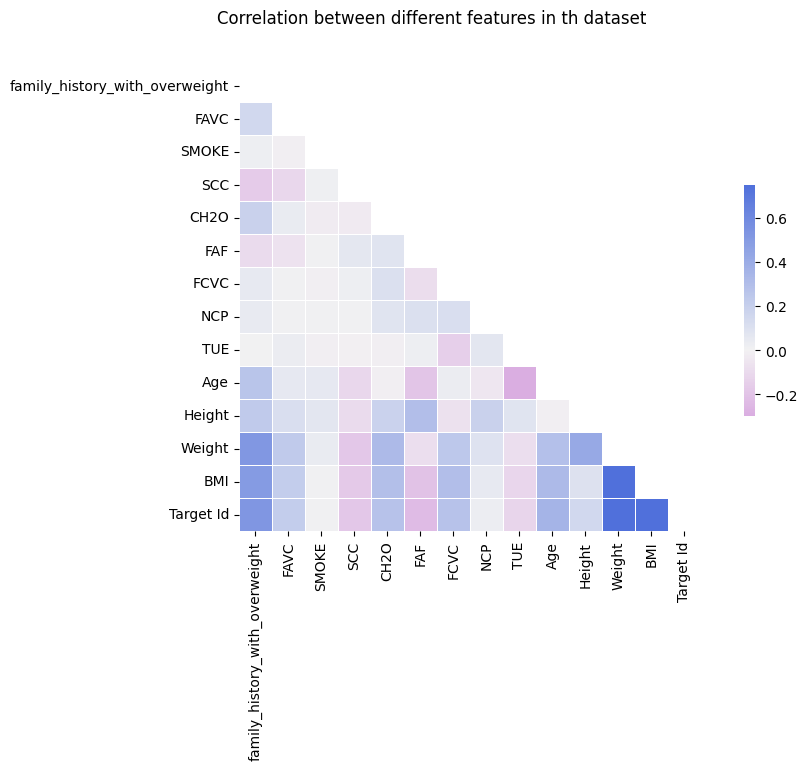


Source: https://www.kaggle.com/code/mariabistro/advanced-visualization-prediction-of-obesity


## Preprocessing

In [5]:
# Add column description (usefull for later interpretation):
column_description_dict = {"FAVC": "Frequent consumption of high caloric food",
                           "FCVC": "Frequency of consumption of vegetables",
                           "NCP": "Number of main meals",
                           "CAEC": "Consumption of food between meals",
                           "CH20": "Consumption of water daily ",
                           "CALC": "Consumption of alcohol",
                           "SCC": "Calories consumption monitoring  ",
                           "FAF": "Physical activity frequency ",
                           "TUE": "Time using technology devices",
                           "MTRANS": "Transportation used",
                          }


# Add unique class ud for each obesity level
target_columns_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
                       'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

idx2label = {str(idx): label for idx, label in enumerate(target_columns_order)}
label2idx = {label: str(idx) for idx, label in enumerate(target_columns_order)}
df["Target Id"] = df["Target"].map(label2idx)
df.drop("Target", axis=1, inplace=True)

### Column encoding

Depending on type of values all columns can be split into three categories:
* categorical_columns - categorical columns which can be ordered, therefore converted to numerical values. Those columns will be encoded using one-hot encoder (dummy encoder)

* ordered_categorical_columns - categorical columns which can be ordered, therefore converted to numerical values, i.e, "sometimes" value can be placed between "no" and "frequently" value.  Those columns will be converted into numeric values from range 0 to 1, where "no" / "never" is represented as 0 and "always" is represented as 1

* numeric_columns - numeric columns are columns where the value has a numerical meaning and can be described quantitativelly. Depending on algorithm in use, those columns should be normalized or can be left without any changes*



$^*$ Models such as linear / logistic regression, support vector machine or neural network require input values to be normalized, whereas decision-trees based algorithms (RandomForest, XGBOOST) can process arbitrary values


In [6]:
## Depending on type of values all columns can be split into three categories:

categorical_columns = ["family_history_with_overweight", "FAVC", "SMOKE", "SCC", "Gender", "MTRANS"]
ordered_categorical_columns = ['CAEC', 'CALC']
numeric_columns = ['CH2O', 'FAF', 'FCVC', 'NCP', 'TUE', 'Age', 'Height', 'Weight', "Target Id"]

In [7]:
df = pd.get_dummies(df, columns=categorical_columns)

In [8]:
frequence_mapping = {"no": 0, "Sometimes": 0.25, "Frequently": 0.75, "Always": 1}

for column_name in ordered_categorical_columns:
    df[column_name] = df[column_name].map(frequence_mapping)

In [9]:
df.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,Target Id,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,Gender_Female,Gender_Male,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,0.25,2.763573,0.000000,0.976473,0.25,3,0,1,0,1,1,0,1,0,0,1,0,0,0,1,0
1,18.000000,1.560000,57.000000,2.000000,3.000000,0.75,2.000000,1.000000,1.000000,0.00,1,0,1,0,1,1,0,1,0,1,0,1,0,0,0,0
2,18.000000,1.711460,50.165754,1.880534,1.411685,0.25,1.910378,0.866045,1.673584,0.00,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0
3,20.952737,1.710730,131.274851,3.000000,3.000000,0.25,1.674061,1.467863,0.780199,0.25,6,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0
4,31.641081,1.914186,93.798055,2.679664,1.971472,0.25,1.979848,1.967973,0.931721,0.25,3,0,1,0,1,1,0,1,0,0,1,0,0,0,1,0


## Prepare training, validation and test datasets

The training dataset is used for training and finetuning models.

The validation data set provides an unbiased evaluation of a model fit on the training data set while tuning the model's hyperparameters. Validation data sets can be used for regularization by early stopping. While fine tunning different models and different hyperparameters set, the final choice of model might be "overfitting" the samples from the validation set. 

The test data set is a data set used to provide an unbiased evaluation of a final model fit on the training data set. The test dataset prevent overfitting by fine-tuned model choice and is the best approximation of the model accuracy on new/unknown data.


In [10]:
X = df.drop("Target Id", axis=1)
y = df["Target Id"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.33, stratify=y_val)

print(f"Train dataset: X = {X_train.shape}, y= {y_train.shape}, / {len(y_train)/len(y) :.2f}%")
print(f"Validation dataset: X = {X_val.shape}, y= {y_val.shape}, / {len(y_val)/len(y) :.2f}%")
print(f"Test dataset: X = {X_test.shape}, y ={y_test.shape} / {len(y_test)/len(y) :.2f}%")

Train dataset: X = (14530, 25), y= (14530,), / 0.70%
Validation dataset: X = (4172, 25), y= (4172,), / 0.20%
Test dataset: X = (2056, 25), y =(2056,) / 0.10%


## Define evaluation metric

In [11]:
def evaluate(model, X_train, y_train, X_val, y_val):
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    train_accuracy = round(accuracy_score(y_train, y_pred_train), 3)
    val_accuracy = round(accuracy_score(y_val, y_pred_val), 3)
    return train_accuracy, val_accuracy

### Test Baseline model

In [12]:
base_model = LGBMClassifier(verbose=0)
base_model.fit(X_train, y_train, eval_set=(X_val, y_val))

train_accuracy, val_accuracy = evaluate(base_model, X_train, y_train, X_val, y_val)
print(f"Train accuracy: {train_accuracy} / test accuracy: {val_accuracy}")


Train accuracy: 0.986 / test accuracy: 0.906


# MLflow Tracking

MLflow Tracking provides a robust API and user interface for logging essential information during the machine learning (ML) process, including parameters, code versions, metrics, and artifacts. This centralized repository captures hyperparameters, metrics, artifacts, data, and environment configurations, offering teams valuable insights into their models’ evolution over time.

## Logging Capabilities

MLflow facilitates the logging and saving of various objects, locally or remotely, for subsequent analysis and comparison:

- **mlflow.log_param() / mlflow.log_params():** Logs hyperparameters used in the ML model.

- **mlflow.log_metric() / mlflow.log_metrics():** Records relevant metrics for easy comparison and evaluation of model performance.

- **mlflow.log_artifact() / log_artifacts():** Logs local files or directories as artifacts of the active run, enabling efficient tracking and management of associated resources.

- **mlflow.lightgbm.log_model():** Provides the ability to log the entire LightGBM model for reference and reproducibility.

#### Running MLflow UI

To visualize and explore the logged information conveniently, follow these steps:

1. If you log runs to a local `mlruns` directory, open the terminal in the project directory.

2. Run the following command to launch the MLflow UI:

   ```bash
   mlflow ui --port 5000
   ```
   
3. Access the MLflow UI by navigating to http://127.0.0.1:5000 in your web browser.


#### Documentation:
https://mlflow.org/docs/latest/tracking/tracking-api.html

In [13]:
feature_names = [
    name.replace(" ", "_").replace("(", "").replace(")", "")
    for name in df.columns
]

# Set our tracking server uri for logging, in this case - local host
#mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("BaseLineModel")

# Start an MLflow run
with mlflow.start_run():
    
    base_model = LGBMClassifier(verbose=0)
    base_model.fit(X_train, y_train, eval_set=(X_val, y_val))
    train_accuracy, val_accuracy = evaluate(base_model, X_train, y_train, X_val, y_val)

    feature_importances = dict(zip(feature_names, base_model.feature_importances_))
    feature_importance_metrics = {
        f"feature_importance_{feature_name}": imp_value
        for feature_name, imp_value in feature_importances.items()
    }

    # Add tag to easily filter out different runs
    mlflow.set_tag("BaselineModel", "Default")    
    
    # log one metric at a time providing a key, value:
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("train_accuracy", val_accuracy)
    
    # log multiple metrics at the same time using a dictioary
    mlflow.log_metrics(feature_importance_metrics)
    
    # Log the model
    signature = infer_signature(X_train, base_model.predict(X_train))
    model_info = mlflow.lightgbm.log_model(
        base_model, "multiclass-classigier", signature=signature,      
        registered_model_name="baseline-model",

    )

    
# Load saved model and make predictions
#lgb_classifier_saved = mlflow.pyfunc.load_model(model_info.model_uri)
#y_pred = lgb_classifier_saved.predict(X_test)
#print(y_pred)

### Grid search with experiment tracking in MLflow

In [22]:
def get_number_of_parameter_sets(model_parameters):
    n_total=1
    for value_list in model_parameters.values():
        n_total *= len(value_list)
    return n_total


def parameters_generator(**params_dict):
    keys = params_dict.keys()
    for instance in itertools.product(*params_dict.values()):
        yield dict(zip(keys, instance))


def find_best_hyperparameters_set(X_train, y_train, X_val, y_val, model_name, model_parameters):

    mlflow.set_experiment(model_name)
    n_total = get_number_of_parameter_sets(model_parameters)

    for run_n, model_kwargs in tqdm(enumerate(parameters_generator(**model_parameters)), total=n_total):
        with mlflow.start_run(run_name=f"run_{run_n}"):

            model = LGBMClassifier(objective="multiclass", early_stopping_round=1, verbose=-10, **model_kwargs)
            model.fit(X_train, y_train, eval_set=(X_val, y_val))
            train_accuracy, val_accuracy = evaluate(model, X_train, y_train, X_val, y_val)
            
            mlflow.log_params(model_kwargs)            
            mlflow.log_metric("train_accuracy", train_accuracy)
            mlflow.log_metric("test_accuracy", val_accuracy)

        mlflow.end_run()

In [23]:
model_parameters = {"num_leaves": [25, 30, 35, 40],
                    "max_depth": [4, 6, 8, 12, 16],
                    "n_estimators": [35, 40, 45, 50],
                    "max_bin": [100, 200, 300, 400],
                    "num_iterations": [30, 40, 50],
                    "min_child_samples": [5],
                    "reg_lambda": [0, 0.05, 0.1],
                    "learning_rate": [0.1, 0.08, 0.05]
}

model_name = "LGBMClassifier"
find_best_hyperparameters_set(X_train, y_train, X_val, y_val, model_name, model_parameters)

8640


  0%|          | 0/8640 [00:00<?, ?it/s]

In [26]:
experiment_id = mlflow.get_experiment_by_name(model_name).experiment_id
experiment_id

'610224602594343598'

In [27]:
client = mlflow.tracking.MlflowClient()
best_run = client.search_runs(
    experiment_id, order_by=["metrics.train_accuracy DESC"], max_results=1
)[0]

print(best_run.info)
print(best_run)

<RunInfo: artifact_uri='file:///home/neofelia/Desktop/kaggle/Multiclass%20prediction/mlruns/610224602594343598/824b67ff333245bea9671db91229dfbb/artifacts', end_time=1706906895760, experiment_id='610224602594343598', lifecycle_stage='active', run_id='824b67ff333245bea9671db91229dfbb', run_name='run_8631', run_uuid='824b67ff333245bea9671db91229dfbb', start_time=1706906894099, status='FINISHED', user_id='neofelia'>
<Run: data=<RunData: metrics={'test_accuracy': 0.906, 'train_accuracy': 0.974}, params={'learning_rate': '0.1',
 'max_bin': '400',
 'max_depth': '16',
 'min_child_samples': '5',
 'n_estimators': '50',
 'num_iterations': '50',
 'num_leaves': '40',
 'reg_lambda': '0'}, tags={'mlflow.runName': 'run_8631',
 'mlflow.source.name': '/home/neofelia/Desktop/kaggle/venv/lib/python3.10/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'neofelia'}>, info=<RunInfo: artifact_uri='file:///home/neofelia/Desktop/kaggle/Multiclass%20prediction/mlruns/610224602